In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import scipy as sp
import os,csv
import statsmodels.api as sm
from scipy import interpolate
import sys
sys.path.append("..")

# === Matplotlib ===
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams


# === Import Maksim's functions === 
# Module in the same directory MD_Capacitance.py
import MD_potential
from MD_potential import *
import MD_capacitance
from MD_capacitance import *

# === Logging ===
import logging
logging.basicConfig()
log=logging.getLogger('ipynb')
log.setLevel(logging.DEBUG)
log.info('logging initialized')

# === Import defined parameters for plotting ===
# Module in the same directory graph_parameters.py
import graph_parameters
from graph_parameters import *
#from graph_parameters import savitzky_golay


# === Import constants ===
# Module in the same directory constants.py
import constants

/home/prace/opt/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
INFO:ipynb:logging initialized
INFO:ipynb:logging initialized


# Field and potential

/home/prace/opt/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1339: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


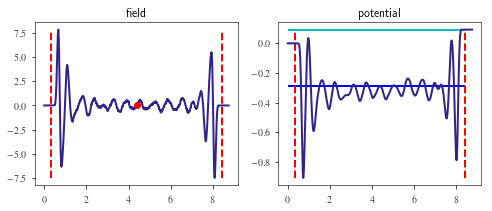

In [2]:
chsim1 = ChgSimulation('/data/Meeri/Experiments/Bi/BMImI/450/a/0.00/', chg_name='charge.xvg',
                       pot_name='potential_mod.xvg', field_name='field_mod.xvg', replicas=['0'], walls=[0.337, 8.410])#, set_chg=True)

chsim1.plot()

#The left subplot shows the field profile and the rigth one -- the potential profile.
#You may play by changing:
#1) the surface charge value "../10.00"
#2) replicas=['1']
#3) walls=[0.730,17.404]
#The red dot indicates a point with minimal field value (close to the centre).
#Blue horizontal line is the potential drop value from the left wall to the bulk.
#Read the value from 0 to the blue line.
#Cyan horizontal line is the potential drop value from the bulk to the right wall.
#Read the value from 0 to the cyan line.

# Load potentials

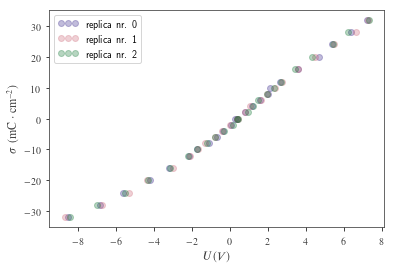

In [5]:
# directory containing base directories for simulations with different electrode surface charges
base_path = '/data/Meeri/Experiments/Bi/BMImI/450/a'

# surface charges to analyze
surf_chgs = [dirs for dirs in os.listdir(base_path) 
              if os.path.isdir(os.path.join(base_path, dirs)) and '.' in dirs]
surf_chgs = sorted(surf_chgs, key=float)

replicas = ['0','1','2']              # which replicas to analyze for each charge
for r in replicas:
    chg_name='charge.xvg'                   # the name of text file containign values of charge depending on z
    generic_data_path = base_path + '/{surf_chg}'  # should reflect directory structure
    # optional
    pot_name = 'potential_mod.xvg'              # the name of text file containign values of potential depending on z
    field_name = 'field_mod.xvg'                # the name of text file containign values of field depending on z
    walls=None
    #Here the position of the walls are specific for each model. 
    #For Au(100), i.e. A1, the position values are 0.730 (left wall) and 17.404 (right wall).
    #0.102 is a half space between Au-Au layers.
    walls = (0.337, 8.410)         
    set_chg = False  # x-y dimensions in nm
    debug = True  # extra printing and plotting
    if debug:
        log.setLevel(level=logging.DEBUG)

    simulations = []
    for surf_chg in surf_chgs:
        p = generic_data_path.format(surf_chg=surf_chg)
        try:
            chsim = ChgSimulation(p, chg_name=chg_name, replicas=r, field_name=field_name, 
                                  pot_name=pot_name, walls=walls, set_chg=set_chg)
            simulations.append(chsim)
            #print surf_chg
            #chsim.plot()
        except IOError:
            log.info('Simulations for surf_chg = {} were not found!, skipping!'.format(surf_chg))
        except Exception as e:
            log.exception(e)
            chsim = ChgSimulation(p, chg_name=chg_name, replicas=replicas, field_name=field_name, 
                                  pot_name=pot_name, walls=walls, log=log)
    pots = compute_potentials(simulations, exclude_outliers=True)
    plt.plot(pots[:,0], pots[:,1], 'o', alpha=0.3, label='replica nr. '+str(r))
plt.xlabel(r'$U (V)$')
plt.ylabel(r'$\sigma$ $(\mathrm{mC\cdot cm^{-2}})$')
#plt.xlim(-5,5)
#plt.ylim(-25,25)
plt.legend(loc='best')

Check that potential looks ok and that there are no outliers

# Capacitance calculations

### Smoothing pot/chg

Capacitance maximum: 14.8172346032
Corresponding charge: 4.004004004
Corresponding potential: 0.741091604367


(0, 20)

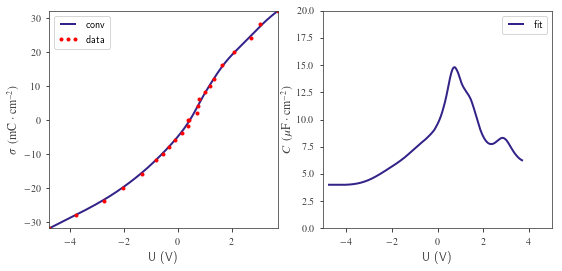

In [6]:
fig, (ax1,ax2) = plot_cap(compute_potentials(simulations, rel_pos=0.102), 
                         w='hamming',
                         fine_ws=261, coarse_ws=200, 
                         chg_left=-20, chg_right=20)
#To play with the plot:
#1) change rel_pos (0.102 is a half space between Au-Au layers).
#2) change fine_ws and coarse_ws=151.
#3) try possible options for w: 'hanning', 'hamming', 'bartlett', 'blackman'.
ax2.set_xlim(-5,5)
ax2.set_ylim(0,20)

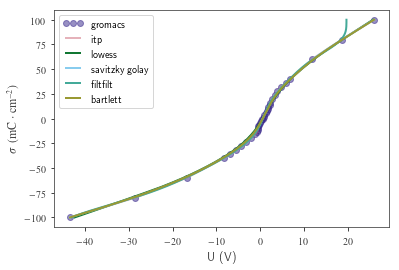

In [5]:
gromacs_data = compute_potentials(simulations, rel_pos=0.102)

pot, chg = gromacs_data[:,0], gromacs_data[:,1]
plt.plot(pot, chg,'o', label='gromacs', alpha=.5)

# interpolate to increase point size
# and regularize grid
chg_itp = np.linspace(chg.min(),chg.max(), 1000)
pot_itp = interpolate.interp1d(chg,pot, kind='linear')
pot_itp = pot_itp(chg_itp)
plt.plot(pot_itp, chg_itp , label='itp', alpha=.5)


# smooth using Locally Weighted Scatterplot Smoothing
# averages points in regions, it and frac are parameters that can 
# be varied if needed.
from statsmodels.nonparametric.smoothers_lowess import lowess
it=3   # doesn't seem to do much
frac=.3 # fraction of data used for each y
#lowess_chg = lowess(chg, pot, frac=frac, it=it, return_sorted=False)
lowess_pot = lowess(pot_itp, chg_itp, frac=frac, it=it, return_sorted=False)
plt.plot(lowess_pot, chg_itp, '-', label='lowess')

# smooth using moving average
from scipy.signal import savgol_filter
window_size, poly_order = 101, 1
sg_pot = savitzky_golay(pot_itp, window_size, poly_order)
plt.plot(sg_pot, chg_itp, label='savitzky golay')

# filtfilt (high-pass filter), applied in two directions
cutoff = 50
fs = 10000
filtfilt_pot = butter_lowpass_filtfilt(pot_itp, cutoff, fs)
plt.plot(filtfilt_pot, chg_itp, '-', label='filtfilt')

# # pchip interpolation
# pchip_pot = sp.interpolate.pchip_interpolate(chg, pot, chg_itp)
# plt.plot(pchip_pot, chg_itp, '-', label='pchip')


# convolution
windows=['flat', 'hanning', 'hamming', 'bartlett', 'blackman']
ws=241
w = windows[3]
# longer extrapolation
dchg = chg_itp[1]-chg_itp[0]
chg_itp_long = np.arange(-200,200,dchg)
# do extrapolation
pot_itp_long_f = sp.interpolate.InterpolatedUnivariateSpline(chg_itp, pot_itp, k=1)
pot_itp_long = pot_itp_long_f(chg_itp_long)
llimit = (ws-1)/2
rlimit = ws-1 - llimit
conv_pot = smooth(pot_itp_long, window_len=ws, window=w)[llimit:-rlimit]
# go back to normal
conv_pot = conv_pot[(chg_itp_long > chg_itp[0]-dchg/2.0) & (chg_itp_long < chg_itp[-1]+dchg/2.0)]
plt.plot(conv_pot,chg_itp,  '-', label=w)


plt.xlabel('U (V)')
plt.ylabel(r'$\sigma$ $(\mathrm{mC\cdot cm^{-2}})$')
plt.legend(loc='best')

Text(0,0.5,'$C$ $(\\mathrm{mF\\cdot cm^{-2}})$')

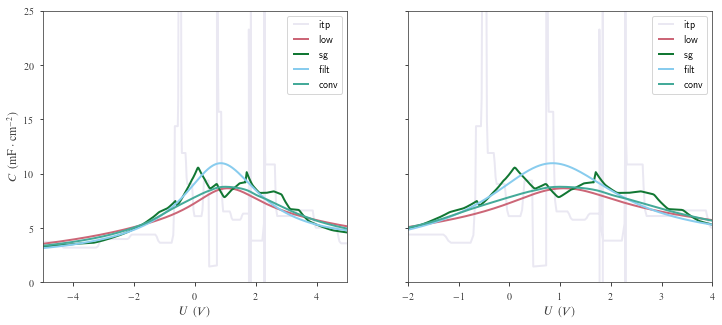

In [6]:
# Numerical derivative
# Here conv is the result of the previous calculations with a fiven "w".

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12,5), sharey=True)
for name, m_pot in zip(['itp', 'low', 'sg', 'filt', 'conv'],
                        [pot_itp, lowess_pot, sg_pot, filtfilt_pot, conv_pot]):
    deriv = num_derivC(m_pot, chg_itp)
    alpha=1.0
    if name=='itp': alpha=.1
    ax1.plot(m_pot, deriv, '-', alpha=alpha, label=name)
    ax2.plot(m_pot, deriv, '-', alpha=alpha, label=name)
    #fig.show()
    
ax1.set_xlim(-5,5)
ax1.set_ylim(0,25)
ax2.set_xlim(-2,4)
ax2.set_ylim(0,25)
ax1.legend(loc='best')
ax2.legend(loc='best')
ax1.set_xlabel('$U$ $(V)$')
ax2.set_xlabel('$U$ $(V)$')
ax1.set_ylabel(r'$C$ $(\mathrm{mF\cdot cm^{-2}})$')

In [7]:
#Save the result
chg_pot_cap = compute_cap(compute_potentials(simulations, rel_pos=.102),itp_points=1000, w='hamming', 
                          fine_ws=261, coarse_ws=151, chg_left=-20, chg_right=20)

np.savetxt('/home/prace/Au100-BMImPF6.txt', chg_pot_cap)

In [8]:
from ipywidgets import interact, interactive, fixed
from IPython.display import clear_output, display, HTML

In [9]:
#Interactive play with the rel_pos

def func(**kwargs):
    plot_cap(compute_potentials(**kwargs))

interactive(func, simulations=fixed(simulations), rel_pos=(0, .2, .01))

interactive(children=(FloatSlider(value=0.1, description=u'rel_pos', max=0.2, step=0.01), Output()), _dom_classes=('widget-interact',))

# Fit function

### fitting cation

      fun: 217.59551555299879
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  0.00000000e+00,   2.84217094e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 18
      nit: 5
   status: 0
  success: True
        x: array([  1.00000000e+03,   5.59915065e-01])


/home/prace/opt/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in power


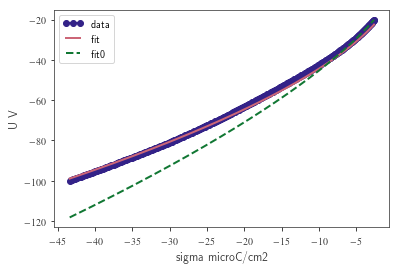

In [19]:
U0 = .5          # Potential of zero charge (V)
U_max_c = -8.7   # Potential of the monolayer formation (V)
theta_max_c = 40 # Maximal surface charge density (microF/cm2)

def sigma_fit(u, theta_max, gamma, a0):
    exponential_term  = a0 + (1 - a0)*np.exp(-gamma*u**2)
    return np.r_[(theta_max*(-u)**(exponential_term))[u<0],-(theta_max*u**(exponential_term))[u>=0]]

def fit_c(x, sigma, U):
    """
    Cation fit objective function
    
    x : list
        Contains: U_max_c (V), gamma_c, a0_c
    """
    gamma_c, a0_c = x
    u = (U - U0)/U_max_c
    sigma_fit_c = sigma_fit(u, theta_max_c, gamma_c, a0_c)
    inv_dist_from_kappa = 1./(np.sqrt(np.abs(sigma_fit(u, theta_max_c, gamma_c, a0_c)+theta_max_c))+1)
    return np.sum(np.abs(sigma-sigma_fit_c)**(2)*inv_dist_from_kappa)


# Define fit region
# sigma_c_fit = gromacs_data[:,1][gromacs_data[:,1] > 30]
# U_c_fit = gromacs_data[:,0][gromacs_data[:,1] > 30]
sigma_c_fit = chg_itp[chg_itp < -20]
U_c_fit = conv_pot[chg_itp < -20]


# initial guess
# gamma, a0
x0 = [ 1000, 0.67]

res = sp.optimize.minimize(fit_c, x0, args=(sigma_c_fit, U_c_fit), bounds=[(0,100000), (0.5, 1)],
                          options={'ftol' : np.finfo(float).eps})
print res
x = res.x

u = (U_c_fit-U0)/U_max_c
plt.plot(U_c_fit, sigma_c_fit,'-o', label='data')
plt.plot(U_c_fit, sigma_fit(u, theta_max_c, x[0], x[1]), '-', label='fit')
plt.plot(U_c_fit, sigma_fit(u, theta_max_c, x0[0], x0[1]), '--', label='fit0')

plt.xlabel('sigma microC/cm2')
plt.ylabel('U V')
plt.legend(loc='best')

      fun: 1400.9756457668611
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  0.00000000e+00,   6.82121026e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 30
      nit: 7
   status: 0
  success: True
        x: array([  8.09294813e+02,   6.15371057e-01])


/home/prace/opt/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in power


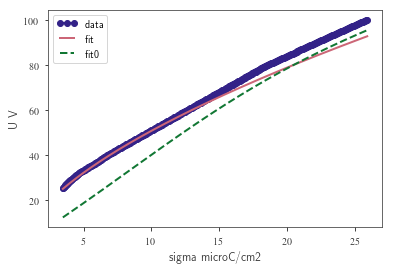

In [20]:
U0 = .5           # Potential of zero charge (V)
U_max_a = 20      # Potential of the monolayer formation (V)
theta_max_a = -80 # Maximal surface charge density (microF/cm2)

def sigma_fit(u, theta_max, gamma, a0):
    exponential_term  = a0 + (1 - a0)*np.exp(-gamma*u**2)
    return np.r_[(theta_max*(-u)**(exponential_term))[u<0],-(theta_max*u**(exponential_term))[u>=0]]

def fit_a(x, sigma, U):
    """
    Cation fit objective function
    
    x : list
        Contains:  gamma_a, a0_a
    """
    gamma_a, a0_a = x
    u = (U - U0)/U_max_a
    sigma_fit_a = sigma_fit(u, theta_max_a, gamma_a, a0_a)
    inv_dist_from_kappa = 1./(np.sqrt(np.abs(sigma_fit(u, theta_max_a, gamma_a, a0_a)+theta_max_a))+1)
    return np.sum(np.abs(sigma-sigma_fit_a)**(2)*inv_dist_from_kappa)


# Define fit region
# sigma_c_fit = gromacs_data[:,1][gromacs_data[:,1] > 30]
# U_c_fit = gromacs_data[:,0][gromacs_data[:,1] > 30]
sigma_a_fit = chg_itp[chg_itp > 25]
U_a_fit = pot_itp[chg_itp > 25]


# initial guess
# gamma, a0
x0 = [ 1, 0.67]

res = sp.optimize.minimize(fit_a, x0, args=(sigma_a_fit, U_a_fit), bounds=[(0,100000), (0.5, 1)],
                          options={'ftol' : np.finfo(float).eps})
print res
x = res.x

u = (U_a_fit-U0)/U_max_a
plt.plot(U_a_fit, sigma_a_fit,'-o', label='data')
plt.plot(U_a_fit, sigma_fit(u, theta_max_a, x[0], x[1]), '-', label='fit')
plt.plot(U_a_fit, sigma_fit(u, theta_max_a, x0[0], x0[1]), '--', label='fit0')

plt.xlabel('sigma microC/cm2')
plt.ylabel('U V')
plt.legend(loc='best')

/home/prace/opt/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in power
  app.launch_new_instance()


NameError: name 'chg_pot_cap' is not defined

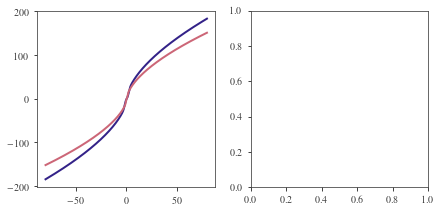

In [21]:
def sigma_fit(u, theta_max, gamma, a0):
    exponential_term  = a0 + (1 - a0)*np.exp(-gamma*u**2)
    return np.r_[(theta_max*(-u)**(exponential_term))[u<0],-(theta_max*u**(exponential_term))[u>=0]]



# data
U0 = .5               # Potential of zero charge (V)
U_max_a =   20 
U_max_c =   8.7
theta_max_a = -80     # microC/cm^2
theta_max_c =  40     # microC/cm^2

# fitted values
gamma_c = 100
a0_c = 0.6
gamma_a = 100
a0_a = 0.6

# individual capacitances
U_fit, dU = np.linspace(-80, 80, num=1000, retstep=True)
u_a = (U_fit-U0)/U_max_a
u_c = (U_fit-U0)/U_max_c

sigma_a = sigma_fit(u_a, theta_max_a, gamma_a, a0_a)
sigma_c = -sigma_fit(u_c, theta_max_c, gamma_c, a0_c)
C_a = np.gradient(sigma_a, dU)
C_c = np.gradient(sigma_c, dU)

# combination of capacitances
gamma_ac = 100#(max(gamma_c, gamma_a)/min(gamma_c, gamma_a))**(1./2)
C_h = 0.5*(C_a+C_c)+ 0.5*(np.tanh(gamma_ac*u_a)*C_a-np.tanh(gamma_ac*u_c)*C_c)

# smoothing
window = sp.signal.gaussian(400, 20)
# convolve the arrays
sC_h = sp.signal.convolve(C_h, window/window.sum(), mode='same')

fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(7,3.25))

ax1.plot(U_fit, sigma_a, label='A')
ax1.plot(U_fit, sigma_c, label='C')
ax1.plot(chg_pot_cap[:,1],chg_pot_cap[:,0],'--',label='data',lw=5)
ax1.set_xlabel('$U$ $V$')
ax1.set_xlim(-60,60)
ax1.set_ylabel('$\sigma$ $\mu C/cm^2$')
ax1.legend(loc='best', fontsize=11)
ax1.locator_params(axis = 'x',nbins=5)

ax2.plot(conv_pot,chg_pot_cap[:,2], '-',lw=5,  label='data',color=color_wheel[2])
#ax2.plot(U_fit, C_a, label='C-a',alpha=.3)
#ax2.plot(U_fit, C_c, label='C-c', alpha=.3)
ax2.plot(U_fit, C_h, label='C', color=color_wheel[3])
#ax2.plot(U_fit, sC_h, label='C sm', color=color_wheel[5])

ax2.set_xlim(-5, 5)
ax2.set_xlabel('$U$ $V$')
ax2.set_ylabel(r'$C$ $(\mathrm{\mu F\cdot cm^{-2}})$')
ax2.locator_params(axis = 'x',nbins=5)

ax2.legend(loc='best', fontsize=11)

fig.tight_layout()
#fig.savefig('../gfx/estimated_cap.png',dpi=300)

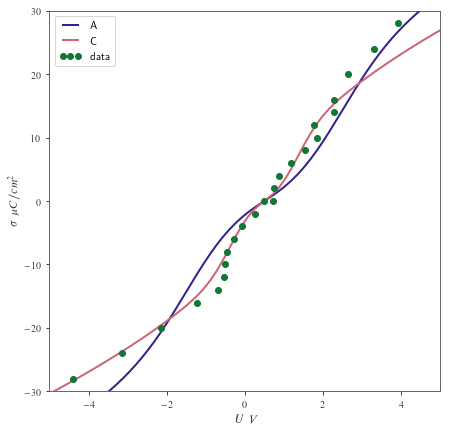

In [29]:
fig, (ax1) = plt.subplots(ncols=1,figsize=(7,7))

ax1.plot(U_fit, sigma_a, label='A')
ax1.plot(U_fit, sigma_c, label='C')
ax1.plot(gromacs_data[:,0],gromacs_data[:,1],'o',label='data',lw=5)
ax1.set_xlabel('$U$ $V$')
ax1.set_xlim(-5,5)
ax1.set_ylim(-30,30)
ax1.set_ylabel('$\sigma$ $\mu C/cm^2$')
ax1.legend(loc='best', fontsize=11)
ax1.locator_params(axis = 'x',nbins=5)

#interp = sp.interpolate.InterpolatedUnivariateSpline(U_fit, sC_h, k=1)
#x_interp = np.linspace(-20, 20, num=1000)
#interp = interp.antiderivative()
#sigma_s = interp(x_interp) 
#ax1.plot(x_interp, sigma_s - 130)

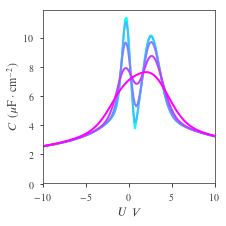

In [24]:
plt.figure(figsize=(3.25,3.25))
plt.xlim(-10, 10)
plt.xlabel('$U$ $V$')
plt.ylabel(r'$C$ $(\mathrm{\mu F\cdot cm^{-2}})$')
#plt.plot(U_fit, C_h, '-', label='C-h',alpha=.1,color='k')
#plt.plot(conv_pot,chg_pot_cap[:,2],'-' , label='fit',alpha=.1,color='k')

import matplotlib.colors as colors
import matplotlib.cm as cmx
values = range(10)
cmap = plt.cm.cool 
line_colors = cmap(np.linspace(0,1,5))

smoothing_factor = [0.5, 1,  2.5, 5, 10]
for i in range(len(smoothing_factor)):
    # smoothing
    window = sp.signal.gaussian(400, smoothing_factor[i])
    # convolve the arrays
    sC_h = sp.signal.convolve(C_h, window/window.sum(), mode='same')
    plt.plot(U_fit, sC_h,label='sC-h'+str(smoothing_factor), alpha=1, color=line_colors[i])

# plt.plot(U_fit, sigma_a, label='A')
# plt.plot(U_fit, sigma_c, label='C')
# plt.xlabel('reduced V')
# plt.ylabel('sigma microC/cm2')
# plt.legend(loc='best')

# plt.show()
#plt.plot(U_fit, C_a, label='C-a')
#plt.plot(U_fit, C_c, label='C-c')
plt.tight_layout()
#plt.savefig('../gfx/smoothing_factor.png',dpi=300)